# 决策树
决策树广泛应用于分类和回归任务的模型。本质上，它从一层层的if/else问题中进行学习，并得出结论。  
这些问题类似于你在“20 Questions”游戏中可能会问的entity。想象一下，你需要区分下面这四种动物：熊、鹰、企鹅和海豚。你的目标是通过提出尽可能少的if/else问题来得到答案。你可能会问：这种动物有没有羽毛，这个问题会将可能的动物减少到只有两种。如果答案是“有”，你可以问下一个问题，帮你区分鹰和企鹅。例如，你可以问这种动物会不会飞。如果这种动物没有羽毛，那么可能是海豚或熊，所以你需要问一个问题来区分这两种动物-比如问这种动物有没有鳍。

In [1]:
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import matplotlib
print("matplotlib version:{}".format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version:{}".format(np.__version__))

import scipy as sp
print("Scipy version:{}".format(sp.__version__))

import IPython
print("IPython version:{}".format(IPython.__version__))

import sklearn
print("scikit-learn version:{}".format(sklearn.__version__))

import mglearn
import graphviz

Python version:3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas version:0.23.4
matplotlib version:3.0.2
Numpy version:1.15.4
Scipy version:1.1.0
IPython version:7.2.0
scikit-learn version:0.20.1


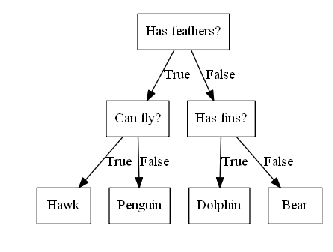

In [2]:
mglearn.plots.plot_animal_tree()

在这张图中，树的每个结点代表一个问题或一个包含答案的终结点（也叫叶节点）。树的边将问题的答案与将问的下一个问题连接起来。  
用机器学习的语言来说就是，为了区分四类动物（鹰、企鹅、海豚和熊），我们利用三个特征（“有没有羽毛”、 “会不会飞”和“有没有鳍”）来构建一个模型。我们可以利用监督学习从数据中学习模型，而无需人为构建模型。

## 构造决策树
学习决策树，就是学习一系列if/else问题，使我们能够以最快的速度得到正确答案。在机器学习中，这些问题叫作测试（不要与测试集弄混，测试集使用测试模型泛化性能的数据）。数据通常并不是像动物的例子那样具有二元特征(是/否）的形式，而是表示为连续特征。用于连续数据的测试形式是：“特征i的值是否大于a?”  
为了构造决策树，算法遍历所有可能的测试，找出对目标变量来说信息量最大的那一个。对数据反复进行递归划分，直到划分后的每个区域（决策树的每个叶节点）只包含单一目标值（单一类别或单一回归值）。如果树中某个叶节点所包含数据点的目标值都相同，那么这个叶节点就是纯的。  
想要对新数据点进行预测，首先要查看这个点位于特征空间划分的哪个区域，然后将该区域的多数目标值（如果是纯的叶结点，就是单一目标值）作为预测结果。从根节点开始对树进行遍历就可以找到这一区域，每一步向左还是向右取决于是否满足相应的测试。  
决策树也可用于回归任务，使用的方法完全相同。预测的方法是，基于每个结点的测试对树进行遍历，最终找到新数据点所属的叶结点。这一数据点的输出即为此叶结点中所有训练点的平均目标值。

# 控制决策树的复杂度
通常来说，构造决策树直到所有叶结点都是纯的叶结点，这会导致模型非常复杂，并且对训练数据高度耦合。纯叶结点的存在说明这棵树在训练集上的精度是100%。训练集中的每个数据点都位于分类正确的叶结点中。
防止过拟合有两种常见的策略：一种是及早停止树的生长，也叫**预剪枝（pre-pruning）**；另一种是先构造树，但随后删除或折叠信息量很少的结点，也叫**后剪枝（post-pruning）或剪枝（pruning）**。预剪枝的限制条件可能包括限制树的最大深度、限制叶结点的最大数目，或者规定一个结点中数据点的最小数目来防止继续划分。  
scikit-learn的决策树在DecisionTreeRegressor和DecisionTreeClassifier类中实现。scikit-learn只实现了预剪枝，没有实现后剪枝。 
我们在乳腺癌数据集上更详细地看一下预剪枝的效果。我们导入数据集并分为训练集和测试集，然后利用默认设置来构建模型，默认将树完全展开（树不断分支，直到所有叶结点都是纯的）。我们固定树的random_state，用于在内部解决平局问题：

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer=load_breast_cancer()
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,stratify=cancer.target,random_state=42)
tree=DecisionTreeClassifier(random_state=0)
tree.fit(X_train,y_train)
print("Accuracy on training set:{:.3f}".format(tree.score(X_train,y_train)))
print("Accuracy on test set:{:.3f}".format(tree.score(X_test,y_test)))

Accuracy on training set:1.000
Accuracy on test set:0.937


不出所料，训练集上的精度是100%，这是因为叶结点都是纯的，树的深度很大，足以完美地记住训练集的所有标签。测试集精度比之前讲过的线性模型略低，线性模型的精度约为95%。  
如果我们不限制决策树的深度，它的深度和复杂度都可以变得特别大。因此，未剪枝的树容易过拟合，对新数据的泛化性能不佳。现在我们将预剪枝应用在决策树上，这可以在完美拟合训练数据正确阻止树的展开。一种选择是在达到一定深度后停止树的展开。我们设置max_depth=4,这意味着只连续问4个问题。限制树的深度可以减少过拟合。这会降低训练集的精度，但可以提高测试集的精度。

In [4]:
tree=DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(X_train,y_train)
print("Accuracy on training set:{:.3f}".format(tree.score(X_train,y_train)))
print("Accuracy on test set:{:.3f}".format(tree.score(X_test,y_test)))

Accuracy on training set:0.988
Accuracy on test set:0.951


# 分析决策树
我们可以利用tree模块的export_graghviz函数来将树可视化。这个函数会生成一个.dot格式的文件，这是一种用于保存图形的文本文件格式。我们设置为结点添加颜色的选项，颜色表示每个结点中的多数类别，同时传入类别名称和特征名称，这样可以对树正确标记：

In [5]:
from sklearn.tree import export_graphviz

export_graphviz(tree,out_file="tree.dot",class_names=["malignant","benign"],feature_names=cancer.feature_names,impurity=False,filled=True)

然后我们可以使用graphviz模块读取这个文件并将其可视化：

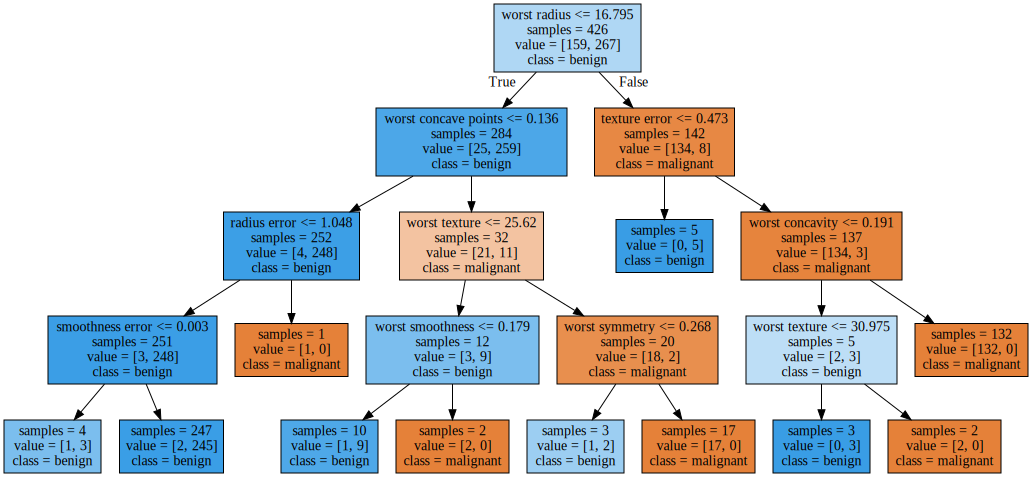

In [6]:
import graphviz

with open("tree.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

树的可视化有助于深入理解算法是如何进行预测的，也是易于向非专家解释的机器学习算法的优秀示例。不过，即使这里的树的深度只有4层，也有点太大了。深度更大的树（深度为10并不罕见）更加难以理解。一种观察树的方法可能有用，就是找出大部分数据的实际路径。

# 树的特征重要性
查看整棵树可能非常费劲，除此之外，我们还可以利用一些有用的属性来总结树的工作原理。其中最常用的是**特征重要性（feature importance）**，它为每个特征对树的决策的重要性进行排序。对于每个特征来说，它都是一个介于0和1之间的数字，其中0表示“根本没用到”，1表示“完美预测目标值”。特征重要性的求和始终为1：

In [7]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


我们将特征重要性可视化：

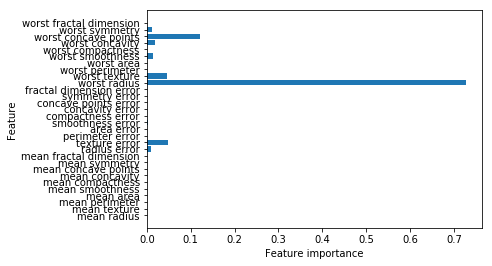

In [8]:
def plot_feature_importances_cancer(model):
    n_features=cancer.data.shape[1]
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)

从上图我们看到，顶部划分用到的特征（“worst radius”）是最重要的特征。这也证实了我们在分析树时的观察结论，即第一层划分已经将两个类别区分的很好。  
但是，如果某个特征的feature_importance_很小，并不能说明这个特征没有提供任何信息。这只能说明该特征没有被树选中，可能是因为另一个特征也包含了同样的信息。  
与线性模型的系数不同，特征重要性始终为正数，也不能说明该特征对应哪个类别。特征重要性告诉我们“worst radius”（最大半径）特征很重要，但并没有告诉我们半径大表示样本是良性还是恶性。事实上，在特征和类别之间可能没有这样简单的关系，我们可以在下面的例子中看出这一点：

Feature importances: [0. 1.]


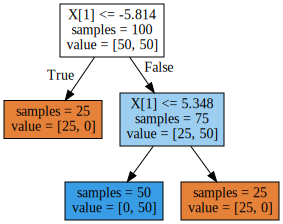

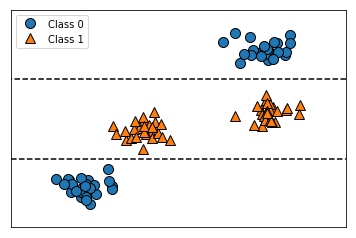

In [9]:
tree=mglearn.plots.plot_tree_not_monotone()
display(tree)

上图显示的是具有两个特征和两个类别的数据集。这里所有信息都包含在X[1]中，没有用到X[0]。但X[1]和输出类别之间并不是单调关系，即我们不能这么说：
“较大的X[1]对应类别0，较小的X[1]对应类别1”（反之亦然）。    
虽然我们主要讨论的是用于分类的决策树，但对于用于回归的决策树来说，所有内容都是类似的，在DecisionTreeRegressor中实现。回归树的用法和分类树非常类似。
但在将基于树的模型用于回归时，我们想要指出它的一个特殊性质。DecisionTreeRegressor（以及其他所有基于树的回归模型）不能**外推（extrapolate）**
也不能在训练数据范围之外进行预测。

我们利用计算机内存（RAM）历史价格的数据集来更详细地研究这一点。

Text(0, 0.5, 'Price in  $/Mbyte')

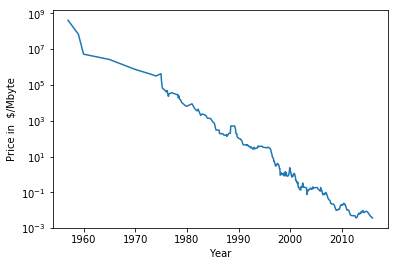

In [26]:
ram_prices=pd.read_csv("data/ram_price.csv")

plt.semilogy(ram_prices.date,ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in  $/Mbyte")

我们将y轴用对数坐标绘图，二者的线性关系看起来非常好，所以预测应该相对比较容易，除了一些不平滑之处之外。  
我们将利用2000年前的历史数据来预测2000年后的价格，只用日期作为特征。我们将对比两个简单的模型：DecisionTreeRegressor和LinearRegression。我们对价格取对数，使得二者关系的线性相对更好。这对DecisionTreeRegressor不会产生什么影响，但对LinearRegression的影响却很大。训练模型并做出预测之后，我们应用指数映射来做对数变换的逆运算。为了便于可视化，我们这里对整个数据集进行预测，但如果为了定量评估，我们将只考虑测试数据集。

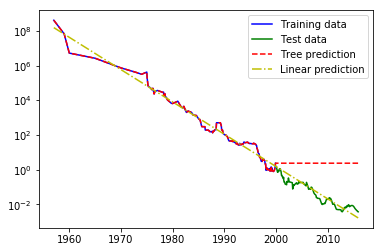

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 利用历史数据预测2000年后的价格
data_train=ram_prices[ram_prices.date<2000]
data_test=ram_prices[ram_prices.date>=2000]

# 基于日期来预测价格
X_train=data_train.date[:,np.newaxis]
# 我们利用对数变换得到数据和目标之间简单的关系
y_train=np.log(data_train.price)

tree=DecisionTreeRegressor().fit(X_train,y_train)
linear_reg=LinearRegression().fit(X_train,y_train)

# 对所有数据进行预测
X_all=ram_prices.date[:,np.newaxis]

pred_tree=tree.predict(X_all)
pred_lr=linear_reg.predict(X_all)

# 对数变换逆运算
price_tree=np.exp(pred_tree)
price_lr=np.exp(pred_lr)

plt.semilogy(data_train.date,data_train.price,label="Training data",color='b')
plt.semilogy(data_test.date,data_test.price,label="Test data",color='g', linestyle='-')
plt.semilogy(ram_prices.date,price_tree,label="Tree prediction",color='r',linestyle='--')
plt.semilogy(ram_prices.date,price_lr,label="Linear prediction",color='y',linestyle='-.')
plt.legend()

两个模型之间的差异非常明显。线性模型用一条直线对数据做近似，这是我们所知道的。  
这条线对测试数据（2000年后的价格）给出了相当好的预测，不过忽略了训练数据和测试数据中一些更细微的变化。与之相反，树模型完美预测了训练数据。由于我们没有限制树的复杂度，因此它记住了整个数据集。但是，一旦输入超出了模型训练数据的范围，模型就只能持续预测最后一个已知数据点。树不能在训练数据的范围之外生成“新的”响应。所有基于树的模型都有整个缺点，或者说是树模型在预测方式上有这一特殊性。

# 优点、缺点和参数
如上所述，控制决策树模型复杂度的参数是预剪枝参数，它在树完全展开之前停止树的构造。通常来说，选择一种预剪枝策略（设置max_depth,max_leaf_nodes或min_samples_leaf）足以 防止过拟合。  
决策树有两个优点：一是得到的模型很容易可视化，非专家也很容易理解（至少对于较小的树而言）；而是算法完全不受数据缩放的影响。由于每个特征被单程处理，而且数据的划分也不依赖与缩放，因此决策树算法不需要特征预处理，比如归一化或标准化。特别是特征的尺度完全不一样或者二元特征和连续特征同时存在时，决策树的效果很好。  
决策树的主要缺点在于，即使做了预剪枝，它也经常过拟合，泛化性能很差。因此，在大多数应用中，往往会使用集成方法来替代单棵决策树。